In [75]:
import pandas as pd
import numpy as np
from datetime import datetime

#Statistical LTV
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

#DNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
#Read data
df = pd.read_excel("Online Retail.xlsx", engine='openpyxl')
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format = '%d/%m/%Y %H:%M')

In [77]:
df['date'] = pd.to_datetime(df.InvoiceDate.dt.date)
df['time'] = df.InvoiceDate.dt.time
df['hour'] = df['time'].apply(lambda x: x.hour)
df['weekend'] = df['date'].apply(lambda x: x.weekday() in [5, 6])
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)

In [78]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,time,hour,weekend,dayofweek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,8,False,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,8,False,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,8,False,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,8,False,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,8,False,2


373 days 00:00:00


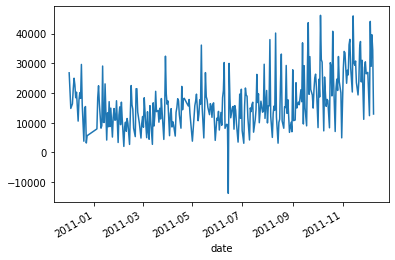

In [79]:
df.groupby('date')['Quantity'].sum().plot()
print(df['date'].max() - df['date'].min())

In [80]:
#Dataset info
print(f'Total Number of Purchases: {df.shape[0]}')
print(f'Total Number of transactions: {df.InvoiceNo.nunique()}')
print(f'Total Unique Days: {df.date.nunique()}')
print(f'Total Unique Customers: {df.CustomerID.nunique()}')
print(f"We are predicting {(df['date'].max() - datetime(2011, 9, 11)).days} days")

Total Number of Purchases: 541909
Total Number of transactions: 25900
Total Unique Days: 305
Total Unique Customers: 4372
We are predicting 89 days


In [81]:
#create revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [82]:
#Context data for the revenue (date & customerID)
id_lookup = df[['CustomerID', 'InvoiceNo', 'date']].drop_duplicates()
id_lookup.index = id_lookup['InvoiceNo']
id_lookup = id_lookup.drop('InvoiceNo', axis=1)

transactions_data = pd.DataFrame(df.groupby('InvoiceNo')['Revenue'].sum()).join(id_lookup)

In [83]:
transactions_data.head()

,Revenue,CustomerID,date
InvoiceNo,,,
536365,139.12,17850.0,2010-12-01
536366,22.20,17850.0,2010-12-01
536367,278.73,13047.0,2010-12-01
536368,70.05,13047.0,2010-12-01
536369,17.85,13047.0,2010-12-01


In [84]:
#Spit into train - test
rfm_train_test = calibration_and_holdout_data(transactions_data, 'CustomerID', 'date',
                                        calibration_period_end='2011-09-10',
                                        monetary_value_col = 'Revenue')   

#Selecting only customers with positive value in the calibration period (otherwise Gamma-Gamma model doesn't work)
rfm_train_test = rfm_train_test.loc[rfm_train_test['monetary_value_cal'] > 0, :]

In [85]:
print(rfm_train_test.shape)
rfm_train_test.head()

(1965, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347.0,4.0,238.0,277.0,519.7675,2.0,759.570000,90.0
12348.0,2.0,110.0,268.0,297.2200,1.0,310.000000,90.0
12352.0,3.0,34.0,206.0,101.5600,3.0,314.743333,90.0
12356.0,1.0,80.0,235.0,481.4600,1.0,58.350000,90.0
12359.0,3.0,142.0,241.0,970.8100,2.0,1392.800000,90.0


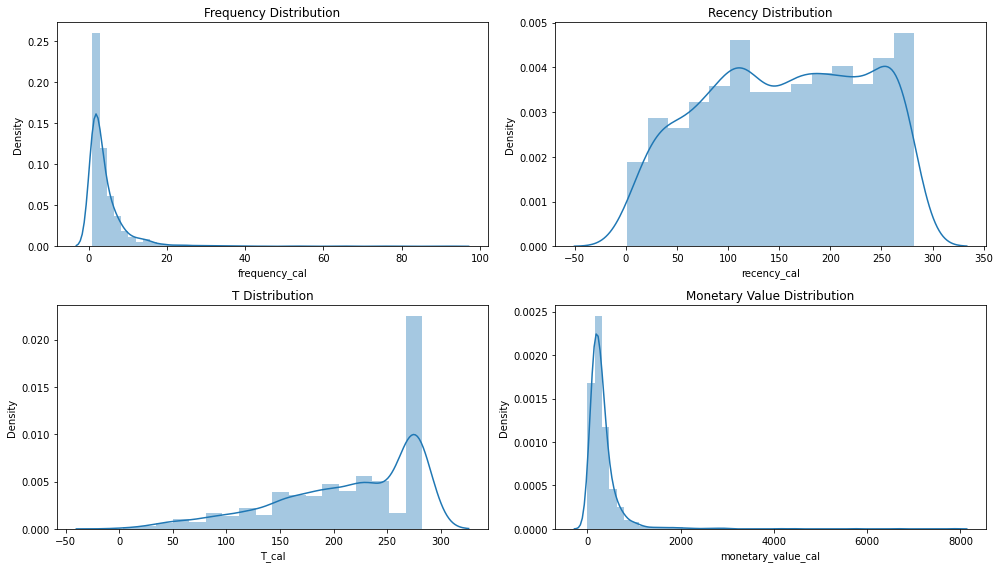

In [86]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_train_test["frequency_cal"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_train_test["recency_cal"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_train_test["T_cal"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_train_test["monetary_value_cal"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

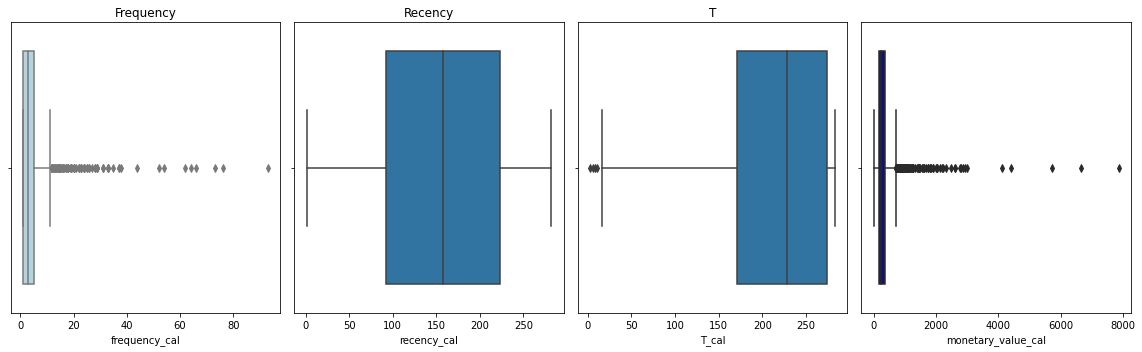

In [87]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_train_test["frequency_cal"], color = "lightblue")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_train_test["recency_cal"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_train_test["T_cal"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_train_test["monetary_value_cal"], color = "darkblue")

plt.tight_layout()

# Modeling

In [88]:
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 1965 subjects, a: 0.01, alpha: 45.52, b: 0.17, r: 1.00>

In [89]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.001777,0.027061,0.948737,1.054816
alpha,45.519041,1.727563,42.133017,48.905064
a,0.008206,0.003099,0.002133,0.014280
b,0.169488,0.040670,0.089775,0.249202


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

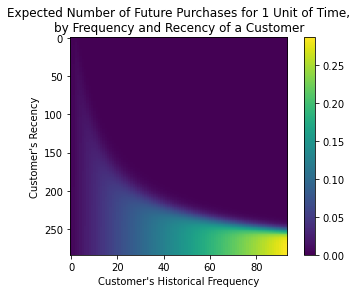

In [90]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

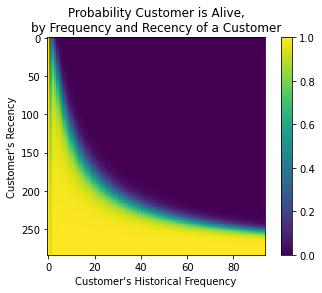

In [91]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [92]:
#Ranking customers from best to worst
t = 1
rfm_train_test['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])
rfm_train_test.sort_values(by='predicted_purchases').tail(5)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases
CustomerID,,,,,,,,
15311.0,64.0,279.0,283.0,696.548125,26.0,449.841563,90.0,0.197804
14606.0,66.0,280.0,283.0,135.527727,22.0,85.690000,90.0,0.203901
12748.0,73.0,282.0,283.0,186.794795,41.0,181.542706,90.0,0.225224
17841.0,76.0,282.0,283.0,296.885132,36.0,302.525088,90.0,0.234355
14911.0,93.0,282.0,283.0,768.926667,52.0,550.064182,90.0,0.286100


To fit Gamma-Gamma model, we first need to make sure that the monetary value and frequency are not correlated as this is one of the basi assumptions of the model.

In [93]:
#Train Gamma-Gamma
rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.00000,0.15412
frequency_cal,0.15412,1.00000


As we see from the table they are not correlated.

In [94]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 1965 subjects, p: 1.29, q: 3.71, v: 708.57>

# Prediction

In [95]:
#Predict the expected number of transactions in the next 89 days
predicted_bgf = bgf.predict(89,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])
trans_pred = predicted_bgf.fillna(0)

#Predict the average order value
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_cal'],
                                        rfm_train_test['monetary_value_cal'])

#Putting it all together
sales_pred = trans_pred * monetary_pred

In [114]:
sales_pred.head()

CustomerID
12347.0    626.042219
12348.0    255.160813
12352.0    203.275779
12356.0    195.284795
12359.0    862.035006
dtype: float64

In [115]:
monetary_pred.head()

CustomerID
12347.0    456.471167
12348.0    317.270278
12352.0    198.406142
12356.0    383.023475
12359.0    709.036274
dtype: float64

# Metrics

In [97]:
def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()

Total Sales Actual: 1742804.0
Total Sales Predicted: 1397434.0
Individual R2 score: 0.6691278084377574 
Individual Mean Absolute Error: 556.7639109686525


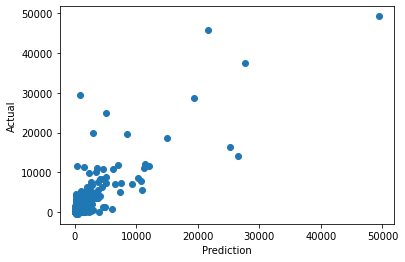

In [98]:
evaluate(actual, sales_pred)

Model is predicting relativly well for 89 days period. 

# Dashboards